In [1]:
import psycopg2
import pandas as pd
import numpy as np
import plotly.express as px

pgparams = {
    "database": "ofetdb_testenv",
    "user":"postgres",
    "password":"password",
    "host": "127.0.0.1",
    "port": "5432"
    }

def read_select_query(query):

    with psycopg2.connect(**pgparams) as conn:

        df = pd.read_sql_query(query, conn)

    return df


In [2]:
q = '''

SELECT measurement_id, sample_id, measurement_type, CAST(data -> 'hole_mobility' ->> 'value' AS FLOAT) AS hole_mobility

FROM measurement

WHERE measurement_type = 'transfer_curve'

'''
read_select_query(q)

C:\Users\Alpha Tauri\AppData\Local\Temp\ipykernel_30268\1979831711.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,measurement_id,sample_id,measurement_type,hole_mobility
0,1,1,transfer_curve,0.110000
1,2,2,transfer_curve,0.290000
2,3,3,transfer_curve,0.230000
3,4,4,transfer_curve,0.730000
4,5,5,transfer_curve,1.860000
...,...,...,...,...
589,590,331,transfer_curve,NaN
590,591,332,transfer_curve,NaN
591,592,333,transfer_curve,NaN
592,593,334,transfer_curve,NaN


In [5]:
q1 = '''

    SELECT 
    measurement.sample_id, common_name, mn, mw, dispersity,
    solution.concentration,
    CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT) AS hole_mobility,
    CAST (data -> 'electron_mobility' ->> 'value' AS FLOAT) AS electron_mobility
    
    FROM 
    measurement, 
    sample, 
    solution NATURAL JOIN solution_makeup_polymer NATURAL JOIN polymer,
    ofet_process
    
    WHERE
    measurement_type = 'transfer_curve' AND
    measurement.sample_id = sample.sample_id AND
    sample.process_id = ofet_process.process_id AND
    ofet_process.solution_id = solution.solution_id AND 
    wt_frac = 1

    '''        


df_1 = read_select_query(q1)
a = df_1.hole_mobility[~pd.isna(df_1.hole_mobility)]
b = df_1.electron_mobility[pd.isna(df_1.hole_mobility)]
df_1['mobility'] = pd.concat([a, b], axis = 0)
df_1 = df_1[df_1.mobility>0]

In [6]:
df_1

,sample_id,common_name,mn,mw,dispersity,concentration,hole_mobility,electron_mobility,mobility
0,1,DPP-DTT,90.0,299.0,3.32,4.0,0.11,NaN,0.11
1,2,DPP-DTT,90.0,299.0,3.32,4.0,0.29,NaN,0.29
2,3,DPP-DTT,90.0,299.0,3.32,4.0,0.23,NaN,0.23
3,4,DPP-DTT,90.0,299.0,3.32,4.0,0.73,NaN,0.73
4,5,DPP-DTT,90.0,299.0,3.32,4.0,1.86,NaN,1.86
...,...,...,...,...,...,...,...,...,...
488,330,N2200,NaN,NaN,NaN,10.0,NaN,0.11,0.11
489,331,N2200,NaN,NaN,NaN,10.0,NaN,0.85,0.85
490,332,N2200,NaN,NaN,NaN,10.0,NaN,3.43,3.43
491,333,N2200,NaN,NaN,NaN,10.0,NaN,0.96,0.96


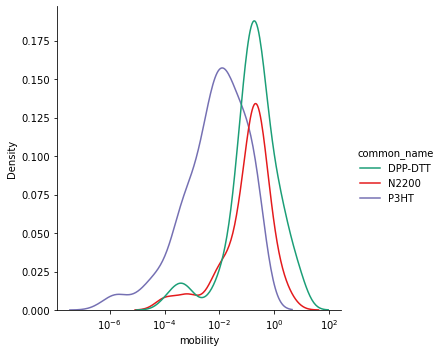

In [4]:
import seaborn as sns

df = df_1.copy()

polymers = pd.unique(df.common_name)

for polymer in polymers:
    
    subset = df[df['common_name']==polymer]

fig = sns.displot(
    df, 
    x="mobility", 
    hue = "common_name", 
    label = polymer, 
    palette = ['#1b9e77','#e41a1c','#7570b3'],
    kind='kde',
    log_scale=True
)

# sns.distplot(x=df["common_name"], y=np.log10(df["mobility"]))

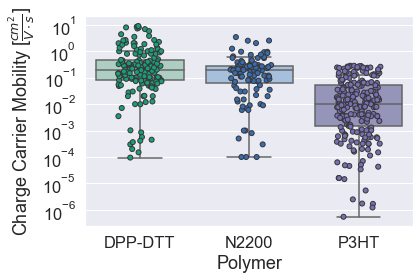

In [5]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
ax = sns.stripplot(
    data=df,
    x = "common_name",
    y="mobility", 
#     kind="boxen",
#     k_depth="trustworthy"
    jitter=0.2,
#     label = polymer,
#     bw=.5
    palette = ['#1b9e77','#386cb0','#7570b3'], linewidth=1, edgecolor='gray'

)


ax = sns.boxplot(
    data=df,
    x = "common_name",
    y="mobility",
    palette = ['#a7d3c4','#9cbfe5','#8f8ebf'], fliersize=0
)

ax.set(xlabel='Polymer', ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]')
plt.yscale("log")
sns.set(rc={'figure.figsize':(8,7)})

fig = ax.get_figure()
fig.tight_layout()
# fig.savefig("out.tif") 

[None,
 Text(0, 0.5, 'Charge Carrier Mobility [$\\frac{cm^2}{V \\cdot s}$]'),
 Text(0.5, 0, '$M_w [kDa]$')]

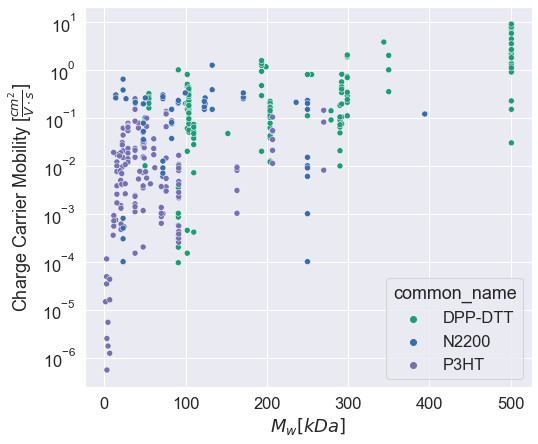

In [6]:
sns.set(rc={'figure.figsize':(8,7)})
sns.set(font_scale=1.5)
ax = sns.scatterplot(
    data = df,
    x = "mw",
    y = "mobility",
    hue = "common_name",
    palette = ['#1b9e77','#386cb0','#7570b3']
)


ax.set(
    yscale='log',
    xlabel='$M_w [kDa]$',
    ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]'
)


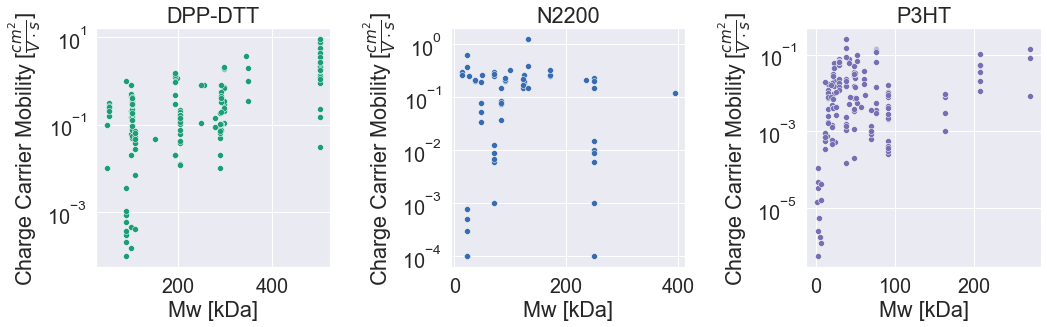

In [107]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.set(font_scale=1.8)
p = ['#1b9e77','#386cb0','#7570b3']
for i, polymer in enumerate(polymers):
    sns.scatterplot(
        data = df[df.common_name==polymer],
        x = "mw",
        y = "mobility",
#         hue = "common_name",
        color = p[i],
        ax=axes[i],
    )
    
    axes[i].set(
        title=polymer,
        xlabel="Mw [kDa]",
        ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]',
        yscale='log',
#         ylim=[1e-7,5e1],
#         xlim=[-20,550]
    )
fig.tight_layout()
fig.savefig("polymer_plots.tif") 

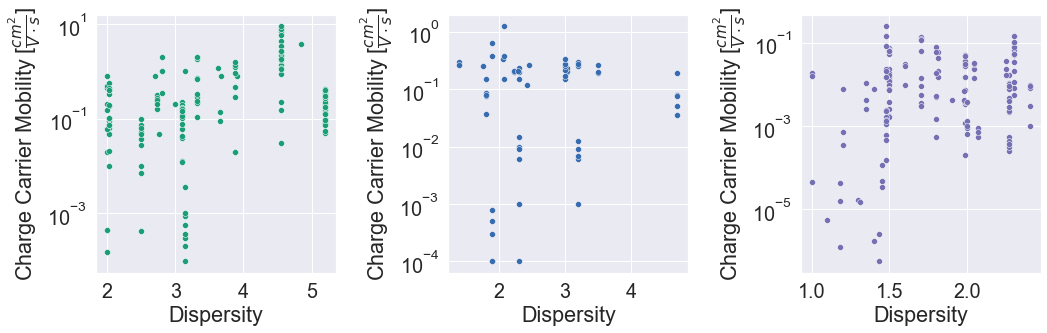

In [106]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.set(font_scale=1.8)
p = ['#1b9e77','#386cb0','#7570b3']
for i, polymer in enumerate(polymers):
    sns.scatterplot(
        data = df[df.common_name==polymer],
        x = "dispersity",
        y = "mobility",
#         hue = "common_name",
        color = p[i],
        ax=axes[i],
    )
    
    axes[i].set(
#         title=polymer,
        xlabel="Dispersity",
        ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]',
        yscale='log',
#         ylim=[1e-7,5e1],
#         xlim=0.9,
    )
fig.tight_layout()

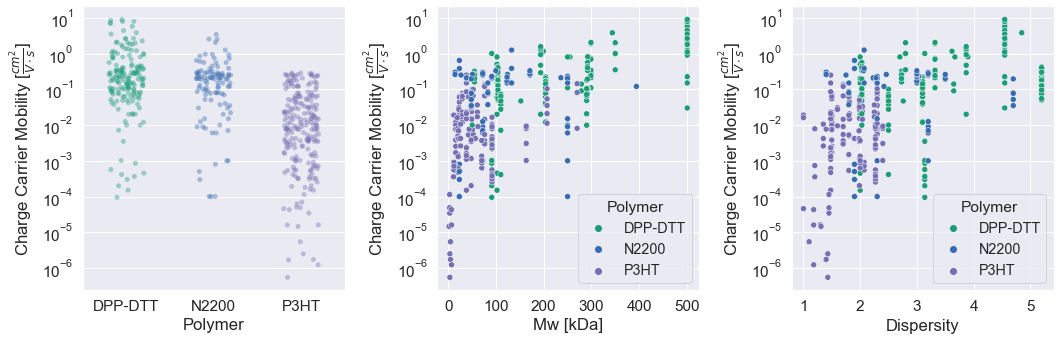

In [244]:
# sns.set_style("whitegrid")

fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.set(font_scale=1.3)

labels = ['Mw [kDa]', 'Dispersity']

sns.stripplot(
    data=df,
    x = "common_name",
    y="mobility", 
    palette = ['#1b9e77','#386cb0','#7570b3'],
    jitter=0.2,
    ax=axes[0],
    alpha=0.4
#     log_y=True
)

axes[0].set(
    xlabel="Polymer",
    ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]',
    yscale='log'

)

sns.scatterplot(
    data = df,
    x = "mw",
    y = "mobility",
    hue = "common_name",
    palette = ['#1b9e77','#386cb0','#7570b3'],
    ax=axes[1],
)

sns.scatterplot(
    data = df,
    x = "dispersity",
    y = "mobility",
    hue = "common_name",
    palette = ['#1b9e77','#386cb0','#7570b3'],
    ax=axes[2],
)
axes[1].legend(title='Polymer')

axes[1].set(
    xlabel="Mw [kDa]",
    ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]',
    yscale='log'

)

axes[2].legend(title='Polymer')

axes[2].set(
    xlabel="Dispersity",
    ylabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]',
    yscale='log'

)

fig.tight_layout()

,mn,mw,dispersity,concentration,d_spacing_010,d_spacing_100
mn,1.000000,0.854898,-0.595180,-0.523435,0.065833,-0.628345
mw,0.854898,1.000000,-0.205911,-0.510341,-0.295692,-0.884285
dispersity,-0.595180,-0.205911,1.000000,0.228534,-0.543073,-0.636538
concentration,-0.523435,-0.510341,0.228534,1.000000,-0.092379,0.640312
d_spacing_010,0.065833,-0.295692,-0.543073,-0.092379,1.000000,0.261844
d_spacing_100,-0.628345,-0.884285,-0.636538,0.640312,0.261844,1.000000


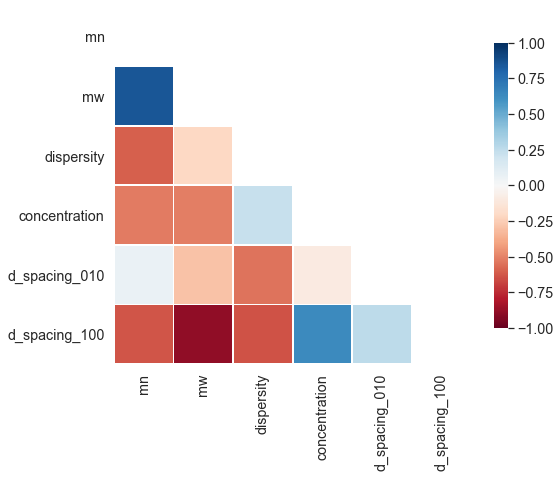

In [102]:
temp = df.drop(['electron_mobility', 'hole_mobility', 'concentration'], axis=1)
temp = df_3
# Generate a mask for the upper triangle

sns.set_style("whitegrid")
corr = temp[temp.common_name=='DPP-DTT'].corr(method='pearson')
# corr = df_3.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
ax = sns.heatmap(
    
    corr, 
    cmap='RdBu',
    mask=mask,
    vmax=1,
    vmin=-1,
    center=0,
    square=True, 
    linewidths=.8, 
    cbar_kws={"shrink": .75}
)

# ax.set(
#     xticklabels=["Mn", "Mw", "PDI", "Mobility"],
#     yticklabels=["Mn", "Mw", "PDI", "Mobility"]
# )
corr

In [167]:
q2 = '''
SELECT 
	measurement.sample_id,
	solution_id,
	CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT) AS mobility,
	array_agg(substrate_pretreat_step.params -> 'sam_name') as sam

FROM 
	substrate_pretreat NATURAL JOIN substrate_pretreat_order NATURAL JOIN substrate_pretreat_step,
	ofet_process,
	sample,
	measurement
	
WHERE
	ofet_process.substrate_pretreat_id = substrate_pretreat.substrate_pretreat_id AND
	sample.process_id = ofet_process.process_id AND
	measurement.sample_id = sample.sample_id AND
	measurement_type = 'transfer_curve' AND CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT) > 0

GROUP BY measurement.sample_id, CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT), solution_id
HAVING COUNT(process_order) = 2

ORDER BY 1

'''
df_2 = read_select_query(q2)
df_2.head()

,sample_id,solution_id,mobility,sam
0,6,2,0.21,"[MTS, OTS-18]"
1,7,2,0.34,"[OTS-18, MTS]"
2,8,2,0.24,"[PTS, OTS-18]"
3,9,2,1.97,"[OTS-18, PTS]"
4,10,2,0.69,"[OTS-8, OTS-18]"


[Text(0, 0.5, 'SAM Sequence'),
 Text(0.5, 0, 'Charge Carrier Mobility [$\\frac{cm^2}{V \\cdot s}$]')]

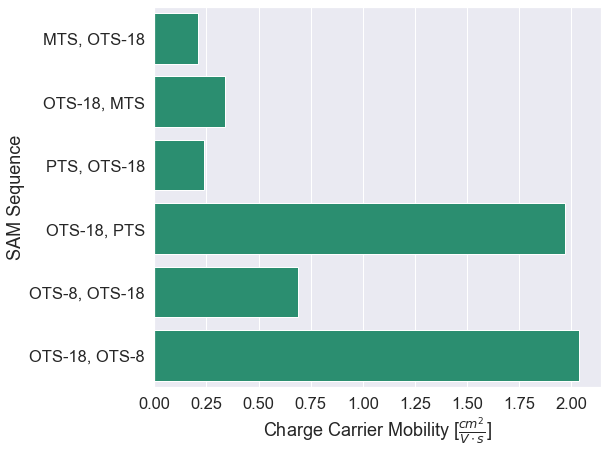

In [203]:
labels = [a+', '+b for a,b in df_2.sam]

ax = sns.barplot(
    data=df_2, 
#     x='sam',
    y='sample_id',
    x='mobility',
    orient='h',
    palette=['#1b9e77']
)
ax.set_yticklabels(labels)

ax.set(
#     xscale='log',
    ylabel='SAM Sequence',
    xlabel=r'Charge Carrier Mobility [$\frac{cm^2}{V \cdot s}$]'
)


In [125]:
q3 = '''
SELECT 
measurement.sample_id, common_name, mn, mw, dispersity,
solution.concentration,
CAST (data -> '010_d_spacing' ->> 'value' AS FLOAT) AS d_spacing_010,
CAST (data -> '100_d_spacing' ->> 'value' AS FLOAT) AS d_spacing_100

FROM 
measurement,
sample, 
solution NATURAL JOIN solution_makeup_polymer NATURAL JOIN polymer,
ofet_process

WHERE
measurement_type = 'giwaxs' AND
measurement.sample_id = sample.sample_id AND
sample.process_id = ofet_process.process_id AND
ofet_process.solution_id = solution.solution_id AND 
wt_frac = 1

'''
df_3 = read_select_query(q3)
df_3.head()

,sample_id,common_name,mn,mw,dispersity,concentration,d_spacing_010,d_spacing_100
0,23,DPP-DTT,110.0,501.0,4.55,5.0,3.43,18.4
1,24,DPP-DTT,110.0,501.0,4.55,5.0,3.43,18.4
2,25,DPP-DTT,110.0,501.0,4.55,5.0,3.43,18.4
3,26,DPP-DTT,110.0,501.0,4.55,5.0,3.43,18.4
4,27,DPP-DTT,110.0,501.0,4.55,5.0,3.43,18.4


,sample_id,mn,mw,dispersity,concentration,d_spacing_010,d_spacing_100
sample_id,1.000000,-0.475078,-0.677761,-0.471778,0.137845,0.815947,0.797554
mn,-0.475078,1.000000,0.862230,-0.328796,-0.489543,-0.165004,-0.772957
mw,-0.677761,0.862230,1.000000,0.036314,-0.456986,-0.408144,-0.875891
dispersity,-0.471778,-0.328796,0.036314,1.000000,0.223275,-0.716399,-0.567870
concentration,0.137845,-0.489543,-0.456986,0.223275,1.000000,-0.083734,0.479313
d_spacing_010,0.815947,-0.165004,-0.408144,-0.716399,-0.083734,1.000000,0.808471
d_spacing_100,0.797554,-0.772957,-0.875891,-0.567870,0.479313,0.808471,1.000000


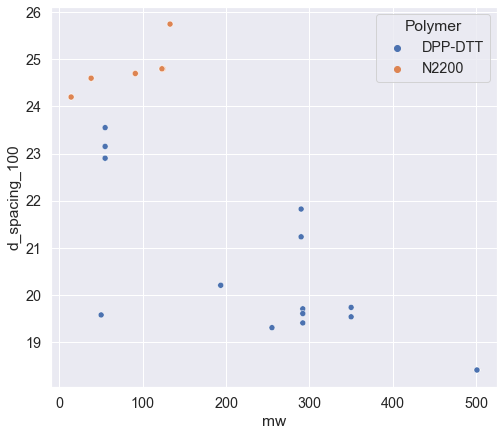

In [127]:
# for i, polymer in enumerate(polymers):
sns.set(font_scale=1.3)
ax = sns.scatterplot(
    data = df_3,
    x = "mw",
    y = "d_spacing_100",
    hue = "common_name",
#     color = p[i],
#     ax=axes[i],
)
ax.legend(title='Polymer')

df_3.corr()

In [118]:
df_3.sample_id.values

array([ 23,  24,  25,  26,  27,  31,  30,  29,  28,  32,  33,  34,  35,
        51,  53,  54,  74,  75,  76,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131,
       132, 133, 134, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 216,
       218, 219, 228, 250, 329, 330, 331, 332, 333, 334], dtype=int64)

In [135]:
sql = '''
    SELECT 
    measurement.sample_id, common_name, mn, mw, dispersity,
    solution.concentration,
    CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT) AS hole_mobility
    
    FROM 
    measurement, 
    sample, 
    solution NATURAL JOIN solution_makeup_polymer NATURAL JOIN polymer,
    ofet_process
    
    WHERE
    measurement_type = 'transfer_curve' AND
    measurement.sample_id = sample.sample_id AND
    CAST (data -> 'hole_mobility' ->> 'value' AS FLOAT) > 0 AND
    sample.process_id = ofet_process.process_id AND
    ofet_process.solution_id = solution.solution_id AND 
    wt_frac = 1

    '''        


df_ = read_select_query(q1)
a = df_.hole_mobility[~pd.isna(df_.hole_mobility)]
b = df_.electron_mobility[pd.isna(df_.hole_mobility)]
df_['mobility'] = pd.concat([a, b], axis = 0)
df_ = df_[df_.mobility>0]


df_ = read_select_query(sql)
df_

,sample_id,common_name,mn,mw,dispersity,concentration,hole_mobility
0,1,DPP-DTT,90.0,299.0,3.32,4.0,0.11000
1,2,DPP-DTT,90.0,299.0,3.32,4.0,0.29000
2,3,DPP-DTT,90.0,299.0,3.32,4.0,0.23000
3,4,DPP-DTT,90.0,299.0,3.32,4.0,0.73000
4,5,DPP-DTT,90.0,299.0,3.32,4.0,1.86000
...,...,...,...,...,...,...,...
368,548,P3HT,68.0,163.2,2.40,3.5,0.00102
369,549,P3HT,68.0,163.2,2.40,3.5,0.00305
370,550,P3HT,68.0,163.2,2.40,3.5,0.00803
371,551,P3HT,68.0,163.2,2.40,3.5,0.00953


In [229]:
mask = df_3[df_3.common_name=='DPP-DTT'][df_3.d_spacing_100>0]
df_giwaxs = mask.set_index('sample_id')
df_giwaxs.index

<ipython-input-229-0255f8a4ef4a>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Int64Index([ 23,  24,  25,  26,  27,  31,  30,  29,  28,  32,  33,  34,  51,
             53,  54,  74,  75,  76, 120, 121, 122, 123, 124, 127, 128, 129,
            130, 131, 132, 133, 134],
           dtype='int64', name='sample_id')

In [230]:
merged = pd.merge(df_.loc[df_giwaxs.index], df_giwaxs)

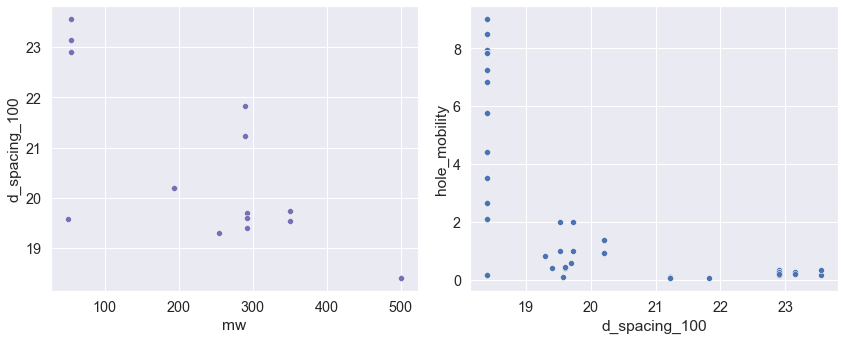

In [234]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.set(font_scale=1.3)
sns.scatterplot(
    data = merged,
    x = "mw",
    y = "d_spacing_100",
    ax = axes[0],
#     hue = "common_name",
    color = p[i]
#     ax=axes[i],
)

sns.set(font_scale=1.3)
sns.scatterplot(
    data = merged,
    x = "d_spacing_100",
    y = "hole_mobility",
    ax = axes[1]
#     hue = "common_name",
#     color = p[i],
#     ax=axes[i],
)
fig.tight_layout()

[]

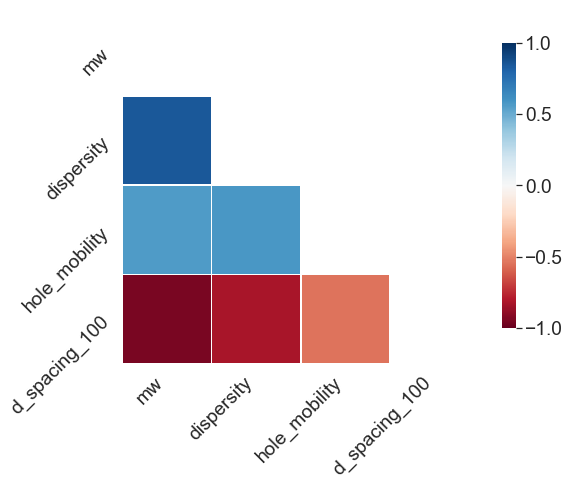

In [237]:
df_3d = merged.loc[:,['mw', 'dispersity', 'hole_mobility', 'd_spacing_100']]

sns.set(font_scale=1.75)
sns.set_style("white")
corr = df_3d.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
ax = sns.heatmap(
    
    corr, 
    cmap='RdBu',
    mask=mask,
    vmax=1,
    vmin=-1,
    center=0,
    square=True, 
    linewidths=.8, 
    cbar_kws={"shrink": .75}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
ax.set(
#     xticklabels=["Mw", "PDI", "Mobility", "(100) d-spacing"],
#     yticklabels=["Mw", "PDI", "Mobility", "(100) d-spacing"]
)

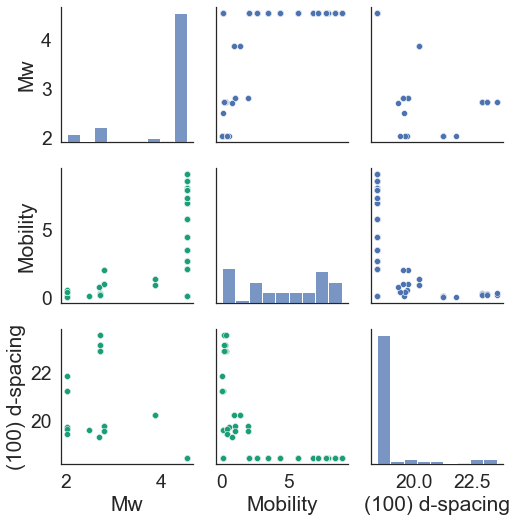

In [238]:
df_3d = merged.loc[:,['dispersity', 'hole_mobility', 'd_spacing_100']]
df_3d_ = df_3d.rename(columns={'dispersity': 'Mw', 'hole_mobility': 'Mobility', 'd_spacing_100':'(100) d-spacing'})
g = sns.pairplot(df_3d_)
g.map_lower(sns.scatterplot, color='#1b9e77')